In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = '../../resources/rat-metabolites/Rat_blood_27_Oct_2022.csv'
blood = pd.read_csv(fpath, index_col='idno')
metabolites = blood.columns[4:]
metabolites2exclude = [m for m in metabolites if blood.loc[:, m].isna().sum() > len(blood) * 0.2]
blood = blood.drop(metabolites2exclude, axis=1)
metabolites = blood.loc[:, 'ca':].columns
blood

,LIScore,Group,material,species,ca,cdca,dca,gca,gcdca,hdca,...,peaec384,peaec385,peaec386,peaec401,peaec404,peaec405,peaec406,pgaac342,pgaac362,psaac384
idno,,,,,,,,,,,,,,,,,,,,,
105,249,AI,plasma,rat,0.4630,0.0561,0.1350,0.2710,0.0398,0.4640,...,0.8563,0.5944,1.0320,0.070930,0.8788,0.6704,0.9606,0.124900,0.093733,0.6516
1158,201,AU,plasma,rat,0.1400,0.2750,1.1000,0.1960,0.0482,3.8500,...,0.7134,0.5287,0.5355,0.068464,0.8386,0.4716,0.5632,0.106300,0.089378,1.3770
1172,155,AU,plasma,rat,0.0855,NaN,0.2630,1.8300,0.0577,0.9180,...,0.7902,0.4731,0.5533,0.049445,1.0500,0.5694,0.6967,0.077505,0.100800,0.3739
1174,194,AU,plasma,rat,NaN,NaN,0.4350,0.3720,0.0157,0.7280,...,0.7210,0.3672,0.4182,NaN,0.9464,0.4536,0.5391,0.131800,0.102600,NaN
127,291,AI,plasma,rat,0.4480,0.0651,0.0117,0.2670,0.0182,0.1100,...,1.0110,0.5756,0.8085,0.063248,1.2450,0.6890,0.9293,0.124300,0.135600,0.6223
1368,285,AI,plasma,rat,2.4400,0.1560,0.1050,1.6900,0.1290,0.5580,...,0.6456,0.3269,0.4058,NaN,0.7900,0.3962,0.5002,0.096018,0.102100,NaN
1416,274,AI,plasma,rat,29.8000,1.5300,0.5010,1.9000,0.0875,2.1500,...,2.0100,0.8612,0.8369,0.086400,1.3110,0.6471,0.7772,1.051000,0.128900,1.4440
1424,216,AU,plasma,rat,4.3700,0.1720,0.1720,1.8800,0.0442,0.4240,...,1.3660,0.7106,0.9118,0.094375,1.6450,0.7576,1.0840,0.116000,0.126200,1.4750
143,280,AI,plasma,rat,9.8400,1.4700,0.4770,15.8000,1.6100,1.4600,...,1.1640,0.6172,0.9476,0.143300,1.5230,0.6772,1.2310,0.150200,0.242300,0.4522


In [3]:
def extract2groups(metabolite, groupA='AU', groupB='AI', df=blood):
    l = [df.loc[df.Group == g, metabolite].dropna() for g in [groupA, groupB]]
    return(l)

def get_log_p(A, B):
    val = - np.log10(stats.ttest_ind(A, B)[1])
    return(val)

def get_effect_size(A, B):
    '''
    The effect size x is B relative to A, so if A > B => x < 0
    '''
    val = B.mean() - A.mean()
    return(val)

def get_both(metabolite, groupA='AU', groupB='AI', df=blood):
    A, B = extract2groups(metabolite, groupA, groupB, df)
    log_p = get_log_p(A, B)
    fx_size = get_effect_size(A, B)
    return((fx_size, log_p))

def get_both_all(groupA='AU', groupB='AI', df=blood):
     l = [get_both(m, 'AU', 'AI', blood) for m in metabolites]
     fx_sizes = [x[0] for x in l]
     log_ps = [x[1] for x in l]
     return((fx_sizes, log_ps))

In [4]:
comparisons = {
    'AI AU': ['AU', 'AI'],
    'AI Y': ['Y', 'AI'],
    'AU Y': ['Y', 'AU'],
              }
results = {k: get_both_all(*v, df=blood) for k, v in comparisons.items()}

(-100.0, 100.0)

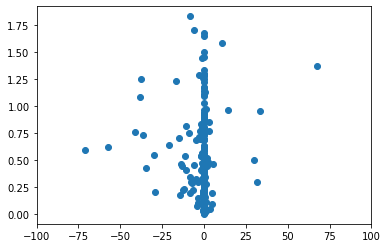

In [5]:
fig, ax = plt.subplots()
ax.scatter(x=results['AI AU'][0], y=results['AI AU'][1])
ax.set_xlim(-100, 100)

In [6]:
%connect_info

{
  "shell_port": 52316,
  "iopub_port": 52317,
  "stdin_port": 52318,
  "control_port": 52320,
  "hb_port": 52319,
  "ip": "127.0.0.1",
  "key": "cb2fa12e-819f522596b9e0431bcd34b6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-16723689-7873-412c-bd4c-0d07e2d30c5f.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
